In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import time
from PIL import Image # For loading single images
from tqdm import tqdm # For progress bar
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models # <-- Make sure 'transforms' is here

# --- ADD THIS NEW IMPORT FOR VISION TRANSFORMER WEIGHTS ---
from torchvision.models import ViT_B_16_Weights # For Vision Transformer Base model, patch size 16x16

from sklearn.metrics import confusion_matrix
import seaborn as sns # For pretty plots, install with `pip install seaborn`

In [3]:
# --- 0. Configuration and Setup ---

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Recommended for reproducibility

In [5]:
# Directories
data_dir = "images"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
model_save_dir = "models"
os.makedirs(model_save_dir, exist_ok=True) # Create models directory if it doesn't exist

In [6]:
# Emotion classes (ensure this matches your folder names)
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(classes)

In [7]:
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 5e-6 # Or even 5e-6. Experiment with this!
NUM_EPOCHS = 30 # You can increase this if needed, but 15 is a good start with transfer learning

In [8]:
# --- 1. Data Transformations ---

# ImageNet normalization values (standard for models pre-trained on ImageNet)
# If your grayscale images are replicated to 3 channels, these are the appropriate means/stds
# for a model pre-trained on RGB images.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [9]:
# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert 1-channel grayscale to 3-channel RGB
    transforms.Resize((224, 224)),              # Resize for MobileNetV3 input

    # --- ADD MORE AUGMENTATIONS HERE ---
    transforms.RandomRotation(15),           # Rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Randomly change brightness, contrast, etc.
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # Add perspective distortion (with 50% probability)
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Randomly crop and resize to introduce scale variations

    
    transforms.RandomHorizontalFlip(),          # Data augmentation
    transforms.ToTensor(),                      # Convert PIL image to PyTorch Tensor
    transforms.Normalize(mean, std)             # Normalize pixel values
])


In [10]:
# For the test set, no random augmentations
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [11]:
# --- 2. Datasets and DataLoaders ---

print("Loading datasets...")
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform) # Use test_transform here

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count() // 2 or 1) # Use half CPU cores
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

print(f"Found {len(train_dataset)} training images.")
print(f"Found {len(test_dataset)} testing images.")
print(f"Detected classes: {train_dataset.classes}")
# Ensure that the dataset classes match the defined `classes` list order if you intend to map them
# directly for classification_report. ImageFolder sorts them alphabetically.
# It's good practice to ensure `classes` list matches `train_dataset.classes` for consistent reporting.
if classes != train_dataset.classes:
    print(f"WARNING: Defined classes {classes} do not match dataset classes {train_dataset.classes}.")
    print("Adjusting `classes` list to match dataset order for reporting.")
    classes = train_dataset.classes # Ensure target_names in report are correct


# --- Calculate Class Weights for Imbalanced Dataset ---
# This ensures that the loss function gives more importance to smaller classes.
import collections # Add this import at the top of your script

print("Calculating class weights...")

# Get counts for each class in the training dataset
# train_dataset.targets contains the numerical labels for each image
class_counts = np.bincount(train_dataset.targets)

# Inverse of class frequencies
class_weights = 1.0 / class_counts

# Normalize weights so they sum to 1 (optional, but good practice)
class_weights = class_weights / class_weights.sum()

# Convert to PyTorch tensor and move to device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights (normalized): {class_weights_tensor.cpu().numpy()}")
print("--- Class Weights Calculated ---")

Loading datasets...
Found 28821 training images.
Found 7066 testing images.
Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Calculating class weights...
Class counts: [3993  436 4103 7164 4982 4938 3205]
Class weights (normalized): [0.06875312 0.6296587  0.06690986 0.03832094 0.05510461 0.05559562
 0.08565716]
--- Class Weights Calculated ---


In [12]:
# --- 3. Model Setup ---

print("Setting up model (Vision Transformer)...")

# Load Vision Transformer Base model, pre-trained on ImageNet
from torchvision.models import ViT_B_16_Weights # Ensure this import is at the top of your file
model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT) # DEFAULT will use the best available weights

# REMOVE or COMMENT OUT this line, it's incorrect for ViT:
# # Or, to get the most up-to-date weights (recommended for future-proofing):
# # model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)


# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# 1. Replace the classifier head for our specific task and unfreeze it
# For ViT, the classifier head is typically at `model.heads.head`
# Its input features are `model.heads.head.in_features`
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, num_classes)
# The new linear layer is automatically trainable, so no explicit for-loop to unfreeze it is needed for just this new layer.


# 2. Fine-tune: Unfreeze the last few blocks of the Transformer encoder
# A ViT model's main learning components are its encoder layers.
# `model.encoder.layers` contains the actual Transformer blocks.
# ViT-B/16 has 12 such blocks (indexed 0 to 11).
num_encoder_blocks = len(model.encoder.layers) # This will correctly be 12 for ViT-B/16
blocks_to_unfreeze_vit = 4 # Experiment with 2, 3, 4, or more (up to 12)

print(f"Unfreezing last {blocks_to_unfreeze_vit} encoder blocks for fine-tuning...")
for i, block in enumerate(model.encoder.layers): # Iterate through encoder layers, not 'features'
    if i >= (num_encoder_blocks - blocks_to_unfreeze_vit):
        for param in block.parameters():
            param.requires_grad = True

# Optionally, unfreeze the patch embedding and positional embedding layers
# This can allow for more adaptation of the initial feature extraction.
# However, for a first ViT run, you might want to keep these frozen to start.
# If you unfreeze them, you might need to drop the LR even further.
# for param in model.patch_embed.parameters():
#     param.requires_grad = True
# for param in model.pos_embedding.parameters():
#     param.requires_grad = True


model = model.to(device)

# Loss and optimizer
# Keep the weighted loss from the previous step!
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Ensure class_weights_tensor is defined

# IMPORTANT: When fine-tuning, use a significantly lower learning rate for the entire model
# as you are now training more layers.
LEARNING_RATE = 5e-6 # Reduced learning rate. Experiment with 1e-6, 5e-7 if needed for ViT.

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler remains the same
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Also, adjust NUM_EPOCHS if you haven't already.
# NUM_EPOCHS = 30 # For ViT, you might need 30-50+ epochs.

Setting up model (Vision Transformer)...
Unfreezing last 4 encoder blocks for fine-tuning...


In [ ]:
# --- 4. Training Function ---

def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs, best_acc, classes, model_save_dir):
    start_time = time.time()

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

            # Update progress bar with current batch metrics
            train_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct_train_predictions/total_train_samples:.4f}")

        # Aggregate epoch metrics for training
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train_predictions / total_train_samples

        # --- Validation Phase ---
        model.eval()
        y_true, y_pred = [], [] # Reset for each validation
        validation_loss = 0.0
        
        with torch.no_grad():
            val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        
        # Aggregate epoch metrics for validation
        val_epoch_loss = validation_loss / len(test_loader.dataset)
        val_acc = accuracy_score(y_true, y_pred) # Use sklearn's accuracy for consistency
        
        # Calculate precision, recall, f1-score for validation
        # Use 'weighted' average to account for class imbalance, if any
        val_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        val_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        scheduler.step(val_epoch_loss) # Tell the scheduler validation loss for this epoch

        # --- Print Epoch Summary (Keras-like format) ---
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # Print Training Metrics
        print(f"  Train: Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
        # Print Validation Metrics
        print(f"  Val  : Loss: {val_epoch_loss:.4f}, Acc: {val_acc:.4f}, "
              f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}, F1: {val_f1:.4f}")


        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model_path = os.path.join(model_save_dir, "best_emotion_vit.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved with accuracy: {best_acc:.4f}")

    # Ensure these lines are correctly unindented to be outside the epoch loop
    end_time = time.time()
    print("\nTraining complete.")
    print(f"Total training time: {(end_time - start_time):.2f} seconds")

    # Final detailed classification report on the test set
    # Note: y_true and y_pred here will reflect the last epoch's validation results.
    print("\n--- Final Evaluation on Test Set ---")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))
    
    return model

# Start training
print("Starting training...")
trained_model = train_model(model, criterion, optimizer, train_loader, test_loader, NUM_EPOCHS, best_acc=0.0, classes=classes, model_save_dir=model_save_dir)

Starting training...



Epoch 1/30
  Train: Loss: 1.5401, Acc: 0.4246
  Val  : Loss: 1.3091, Acc: 0.5069, Prec: 0.5191, Rec: 0.5069, F1: 0.5034
Best model saved with accuracy: 0.5069



Epoch 2/30
  Train: Loss: 1.2630, Acc: 0.5329
  Val  : Loss: 1.1679, Acc: 0.5667, Prec: 0.5794, Rec: 0.5667, F1: 0.5659
Best model saved with accuracy: 0.5667



Epoch 3/30
  Train: Loss: 1.1615, Acc: 0.5667
  Val  : Loss: 1.1040, Acc: 0.5927, Prec: 0.5941, Rec: 0.5927, F1: 0.5859
Best model saved with accuracy: 0.5927



Epoch 4/30
  Train: Loss: 1.0975, Acc: 0.5896
  Val  : Loss: 1.0774, Acc: 0.6020, Prec: 0.6119, Rec: 0.6020, F1: 0.5996
Best model saved with accuracy: 0.6020



Epoch 5/30
  Train: Loss: 1.0390, Acc: 0.6100
  Val  : Loss: 1.0539, Acc: 0.6056, Prec: 0.6058, Rec: 0.6056, F1: 0.5974
Best model saved with accuracy: 0.6056



Epoch 6/30
  Train: Loss: 0.9898, Acc: 0.6235
  Val  : Loss: 1.0255, Acc: 0.6172, Prec: 0.6160, Rec: 0.6172, F1: 0.6081
Best model saved with accuracy: 0.6172



Epoch 7/30
  Train: Loss: 0.9554, Acc: 0.6369
  Val  : Loss: 1.0465, Acc: 0.6115, Prec: 0.6228, Rec: 0.6115, F1: 0.6072



Epoch 8/30
  Train: Loss: 0.9077, Acc: 0.6498
  Val  : Loss: 1.0222, Acc: 0.6254, Prec: 0.6284, Rec: 0.6254, F1: 0.6154
Best model saved with accuracy: 0.6254



Epoch 9/30
  Train: Loss: 0.8803, Acc: 0.6593
  Val  : Loss: 0.9913, Acc: 0.6323, Prec: 0.6352, Rec: 0.6323, F1: 0.6285
Best model saved with accuracy: 0.6323



Epoch 10/30
  Train: Loss: 0.8509, Acc: 0.6717
  Val  : Loss: 0.9837, Acc: 0.6353, Prec: 0.6354, Rec: 0.6353, F1: 0.6316
Best model saved with accuracy: 0.6353



Epoch 11/30
  Train: Loss: 0.8125, Acc: 0.6835
  Val  : Loss: 0.9796, Acc: 0.6363, Prec: 0.6402, Rec: 0.6363, F1: 0.6272
Best model saved with accuracy: 0.6363



Epoch 12/30
  Train: Loss: 0.7918, Acc: 0.6908
  Val  : Loss: 0.9755, Acc: 0.6391, Prec: 0.6429, Rec: 0.6391, F1: 0.6395
Best model saved with accuracy: 0.6391



Epoch 13/30
  Train: Loss: 0.7645, Acc: 0.6987
  Val  : Loss: 0.9779, Acc: 0.6325, Prec: 0.6407, Rec: 0.6325, F1: 0.6349



Epoch 14/30
  Train: Loss: 0.7382, Acc: 0.7102
  Val  : Loss: 0.9606, Acc: 0.6441, Prec: 0.6439, Rec: 0.6441, F1: 0.6424
Best model saved with accuracy: 0.6441



Epoch 15/30
  Train: Loss: 0.7195, Acc: 0.7173
  Val  : Loss: 0.9691, Acc: 0.6434, Prec: 0.6479, Rec: 0.6434, F1: 0.6391



Epoch 16/30
  Train: Loss: 0.6951, Acc: 0.7249
  Val  : Loss: 0.9708, Acc: 0.6393, Prec: 0.6429, Rec: 0.6393, F1: 0.6372



Epoch 17/30
  Train: Loss: 0.6698, Acc: 0.7365
  Val  : Loss: 0.9707, Acc: 0.6476, Prec: 0.6523, Rec: 0.6476, F1: 0.6474
Best model saved with accuracy: 0.6476



Epoch 18/30
  Train: Loss: 0.6388, Acc: 0.7488
  Val  : Loss: 0.9782, Acc: 0.6439, Prec: 0.6438, Rec: 0.6439, F1: 0.6390



Epoch 19/30
  Train: Loss: 0.6180, Acc: 0.7555
  Val  : Loss: 0.9758, Acc: 0.6479, Prec: 0.6546, Rec: 0.6479, F1: 0.6486
Best model saved with accuracy: 0.6479



Epoch 20/30
  Train: Loss: 0.5970, Acc: 0.7625
  Val  : Loss: 0.9907, Acc: 0.6470, Prec: 0.6533, Rec: 0.6470, F1: 0.6409



Epoch 21/30
  Train: Loss: 0.5402, Acc: 0.7895
  Val  : Loss: 0.9724, Acc: 0.6533, Prec: 0.6471, Rec: 0.6533, F1: 0.6478
Best model saved with accuracy: 0.6533



Epoch 22/30
  Train: Loss: 0.5303, Acc: 0.7932
  Val  : Loss: 0.9717, Acc: 0.6527, Prec: 0.6507, Rec: 0.6527, F1: 0.6495



Epoch 23/30
  Train: Loss: 0.5315, Acc: 0.7940
  Val  : Loss: 0.9762, Acc: 0.6510, Prec: 0.6525, Rec: 0.6510, F1: 0.6501



Epoch 24/30
  Train: Loss: 0.5218, Acc: 0.7966
  Val  : Loss: 0.9746, Acc: 0.6555, Prec: 0.6516, Rec: 0.6555, F1: 0.6512
Best model saved with accuracy: 0.6555



Epoch 25/30
  Train: Loss: 0.5220, Acc: 0.7990
  Val  : Loss: 0.9794, Acc: 0.6517, Prec: 0.6492, Rec: 0.6517, F1: 0.6487



Epoch 26/30
  Train: Loss: 0.5138, Acc: 0.7989
  Val  : Loss: 0.9797, Acc: 0.6523, Prec: 0.6498, Rec: 0.6523, F1: 0.6495



Epoch 27/30
  Train: Loss: 0.5109, Acc: 0.8000
  Val  : Loss: 0.9794, Acc: 0.6540, Prec: 0.6509, Rec: 0.6540, F1: 0.6511



Epoch 28/30
  Train: Loss: 0.5106, Acc: 0.8022
  Val  : Loss: 0.9793, Acc: 0.6531, Prec: 0.6501, Rec: 0.6531, F1: 0.6502



Epoch 29/30
  Train: Loss: 0.5079, Acc: 0.8034
  Val  : Loss: 0.9796, Acc: 0.6523, Prec: 0.6498, Rec: 0.6523, F1: 0.6497



Epoch 30/30
  Train: Loss: 0.5095, Acc: 0.8017
  Val  : Loss: 0.9792, Acc: 0.6530, Prec: 0.6499, Rec: 0.6530, F1: 0.6500

Training complete.
Total training time: 14490.84 seconds

--- Final Evaluation on Test Set ---
              precision    recall  f1-score   support

       angry     0.5780    0.5594    0.5686       960
     disgust     0.6220    0.7117    0.6639       111
        fear     0.5245    0.4204    0.4667      1018
       happy     0.8522    0.8433    0.8477      1825
     neutral     0.5899    0.6530    0.6198      1216
         sad     0.5087    0.5127    0.5107      1139
    surprise     0.7304    0.8193    0.7723       797

    accuracy                         0.6530      7066
   macro avg     0.6294    0.6457    0.6357      7066
weighted avg     0.6499    0.6530    0.6500      7066




--- Testing Single Image Prediction ---

Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/sad/42.jpg
Model prediction: sad (Confidence: 51.76%)


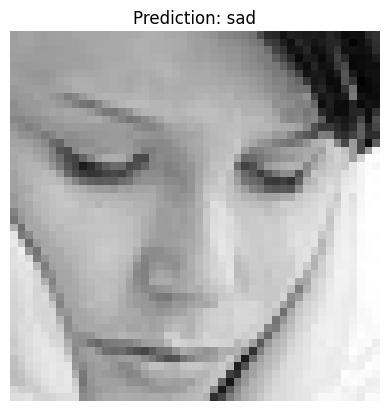


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/fear/2.jpg
Model prediction: sad (Confidence: 73.98%)


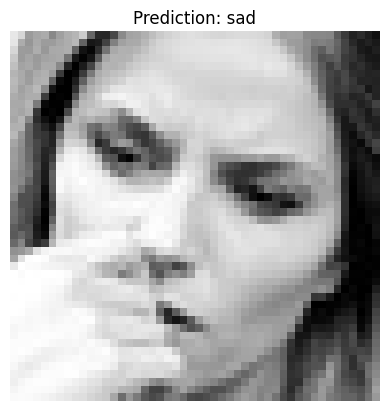


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/disgust/299.jpg
Model prediction: angry (Confidence: 52.11%)


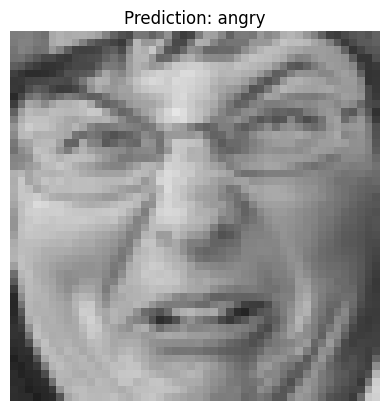


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/happy/7.jpg
Model prediction: happy (Confidence: 99.23%)


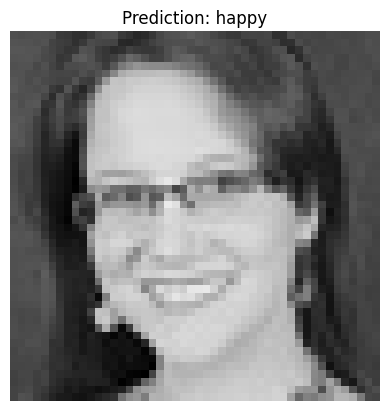


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/train/surprise/15.jpg
Model prediction: surprise (Confidence: 84.99%)


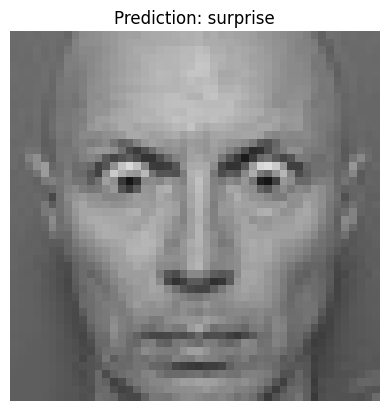


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/test/neutral/8919.jpg
Model prediction: neutral (Confidence: 95.07%)


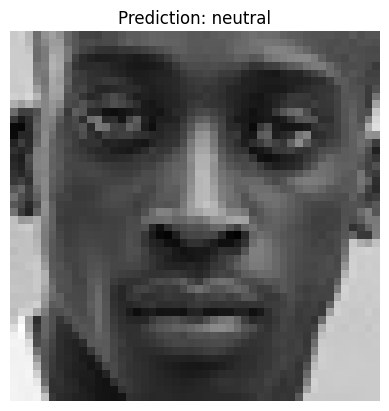


Loading best model weights from: models\best_mobilenetv3_emotion.pth
Original image from: images/test/angry/5732.jpg
Model prediction: angry (Confidence: 97.40%)


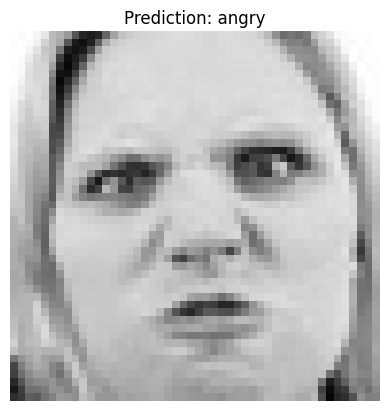

In [48]:
# --- 6. Load Best Model and Predict Single Image ---

def predict_single_image(model, image_path, classes, transform, device, model_weights_path=None):
    """
    Loads a model, predicts the class of a single image, and displays it.
    """
    # Load the model state dictionary if provided
    if model_weights_path and os.path.exists(model_weights_path):
        print(f"\nLoading best model weights from: {model_weights_path}")
        # Create a fresh model instance to load weights into
        # Need to reconstruct the model architecture exactly as it was saved
        # This part assumes you want to load the best model for inference after training
        # If 'model' is already the trained_model, you don't need to load again.
        
        # To be safe and load the *best* model saved during training:
        if isinstance(model, nn.Module): # Check if it's already a PyTorch model
            # Re-initialize the model if needed, or assume it's the correct structure
            # For this context, we'll assume `model` passed to this function is the one that was saved
            pass
        else:
            # You would reconstruct the model here, e.g.:
            # model = models.mobilenet_v3_large(weights=None) # Start with uninitialized weights
            # in_features_reconstruct = model.classifier[3].in_features
            # model.classifier[3] = nn.Linear(in_features_reconstruct, len(classes))
            # model = model.to(device)
            pass # Keep using the passed 'model' for simplicity now.
            
        model.load_state_dict(torch.load(model_weights_path, map_location=device, weights_only=True))
    
    model.eval() # Set model to evaluation mode
    
    try:
        # Load the image
        img = Image.open(image_path).convert('RGB')
        print(f"Original image from: {image_path}")

        # Apply the same transformations as the test set
        img_tensor = transform(img).unsqueeze(0).to(device) # Add batch dimension

        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)
            probabilities = torch.softmax(output, dim=1)
            _, predicted_idx = torch.max(probabilities, 1)
            
            pred_label = classes[predicted_idx.item()]
            confidence = probabilities[0, predicted_idx.item()].item() * 100

        print(f"Model prediction: {pred_label} (Confidence: {confidence:.2f}%)")
        
        # Display the image
        plt.imshow(img)
        plt.title(f"Prediction: {pred_label}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage for single image prediction
print("\n--- Testing Single Image Prediction ---")
test_image_paths = [
    'images/train/sad/42.jpg',
    'images/train/fear/2.jpg',
    'images/train/disgust/299.jpg',
    'images/train/happy/7.jpg',
    'images/train/surprise/15.jpg',
    'images/test/neutral/8919.jpg',
    'images/test/angry/5732.jpg'# Example from test set
]

for img_path in test_image_paths:
    # Use the best model saved during training for prediction
    predict_single_image(trained_model, img_path, classes, test_transform, device, 
                         model_weights_path=os.path.join(model_save_dir, "best_mobilenetv3_emotion.pth"))
    time.sleep(1)



--- Generating Confusion Matrix for Best Model ---


C:\Users\vanel\AppData\Local\Temp\ipykernel_16144\4127145765.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best.load_state_dict(torch.load(best_model_path, map_

Loaded best model from: models\best_mobilenetv3_emotion.pth


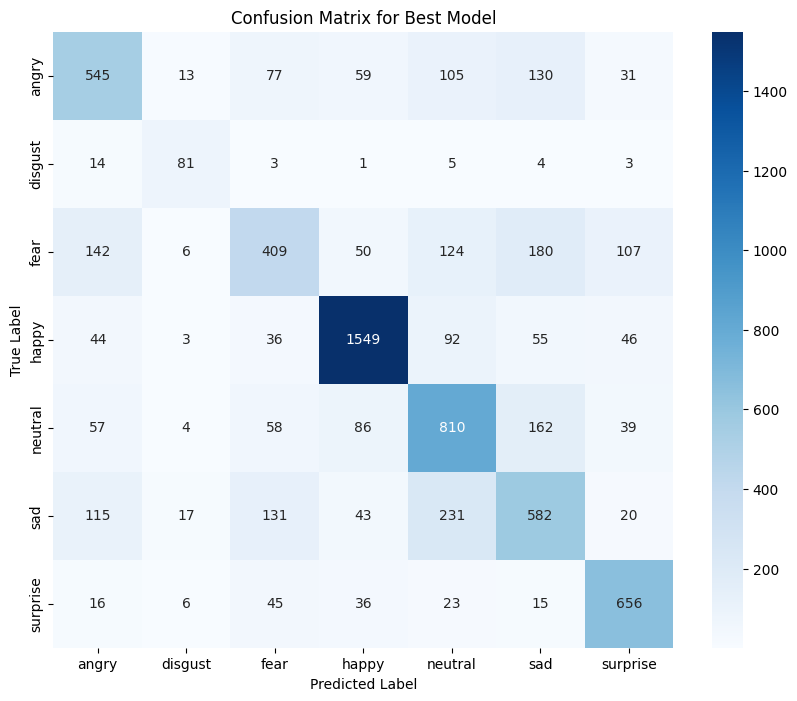

In [50]:
print("\n--- Generating Confusion Matrix for Best Model ---")

# Re-initialize the model to ensure you're loading into the correct structure
model_best = models.vit_b_16(weights=None) # Start with uninitialized weights
in_features_best = model_best.heads.head.in_features
model_best.heads.head = nn.Linear(in_features_best, num_classes)
model_best = model_best.to(device)

# Load the state dict of the best saved model
best_model_path = os.path.join(model_save_dir, "best_mobilenetv3_emotion.pth") # Note: This file now contains ViT weights
if os.path.exists(best_model_path):
    model_best.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from: {best_model_path}")
else:
    print("Best model not found. Cannot generate confusion matrix.")
    # Fallback: use the last trained model if best not found or if you didn't save.
    # model_best = trained_model
    # print("Using the last trained model for confusion matrix.")
    
model_best.eval() # Set to evaluation mode

y_true_best = []
y_pred_best = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Collecting predictions for Confusion Matrix"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_best(images)
        _, predicted = torch.max(outputs, 1)
        y_true_best.extend(labels.cpu().numpy())
        y_pred_best.extend(predicted.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(y_true_best, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best Model')
plt.show()


--- Analyzing Misclassified Images (First 5 examples) ---


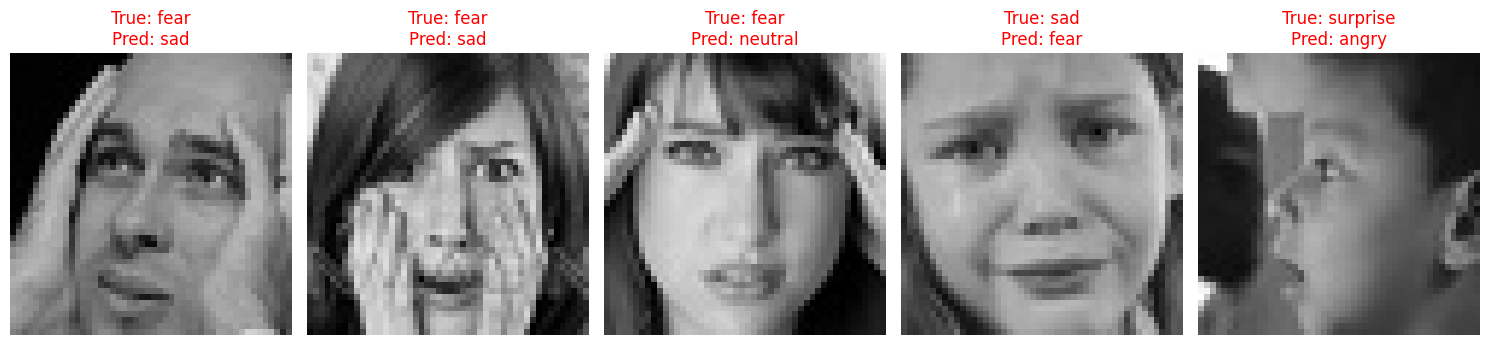

In [53]:
print("\n--- Analyzing Misclassified Images (First 5 examples) ---")

misclassified_indices = np.where(np.array(y_true_best) != np.array(y_pred_best))[0]
np.random.shuffle(misclassified_indices) # Shuffle to get varied examples

num_display = 5 # Number of misclassified images to display

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:num_display]):
    true_label = classes[y_true_best[idx]]
    predicted_label = classes[y_pred_best[idx]]
    image_path = test_dataset.imgs[idx][0] # Access original image path from ImageFolder

    # Load and display the original image
    img = Image.open(image_path).convert('RGB')

    plt.subplot(1, num_display, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Exporting Model to TorchScript (via Scripting) ---")
try:
    # Script the entire model
    scripted_model = torch.jit.script(model_best)
    torchscript_path_script = os.path.join(model_save_dir, "best_emotion_vit_scripted.pt")
    scripted_model.save(torchscript_path_script)
    print(f"Model successfully exported to TorchScript (scripted): {torchscript_path_script}")
except Exception as e:
    print(f"Error exporting model via Scripting: {e}")



--- Exporting Model to TorchScript (via Scripting) ---
Model successfully exported to TorchScript (scripted): models\best_emotion_vit_scripted.pt
